In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import typing as T
from tqdm import tqdm
import torch
import numpy as np

from esm.esmfold.v1.misc import batch_encode_sequences
from evo.dataset import FastaDataset

import k_diffusion as K
import matplotlib.pyplot as plt
import seaborn as sns

seq_len = 1289
num_to_calculate = 5000
normalization = "channel_standardize"

fasta_file: str = "/shared/amyxlu/data/uniref90/uniref90.fasta" 
device_id: int = 0
batch_size: int = 64


/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# take a subset of the whole database
dataset = FastaDataset(fasta_file, cache_indices=True)
print("Full dataset length:", len(dataset))

esmfold = K.models.esmfold.ESMFold()
device = torch.device(f"cuda:2")
esmfold = esmfold.to(device)
esmfold.set_chunk_size(128)

Full dataset length: 153742194


In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))

In [5]:
sequences = K.utils.get_random_sequence_crop_batch(batch[1], 512)

with torch.no_grad():
    output = esmfold.infer_embedding(sequences)
    
s, mask = output['s'], output['mask']
mask = mask.unsqueeze(-1).expand_as(s)
s_ = s * mask
print(s.mean(), s.std())
print(s_.mean(), s_.std())

tensor(1.3068, device='cuda:2') tensor(71.8468, device='cuda:2')
tensor(0.7428, device='cuda:2') tensor(56.6876, device='cuda:2')


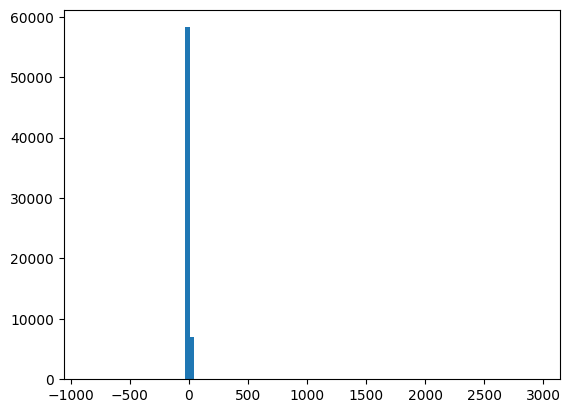

In [6]:
# what's the distribution of raw values?
_ = plt.hist(s_[:100, 10, :].flatten().cpu().numpy(), bins=100)

In [7]:
channel_mean = (s_ * mask).sum(dim=(0,1)) / mask.sum(dim=(0,1))

tensor([ 1.2580,  0.8697,  2.9118,  ..., -2.5584, -4.6455,  0.0752],
       device='cuda:2')
tensor(2276.0786, device='cuda:2')
tensor(-694.6569, device='cuda:2')
tensor(1.3056, device='cuda:2')
tensor(74.5053, device='cuda:2')


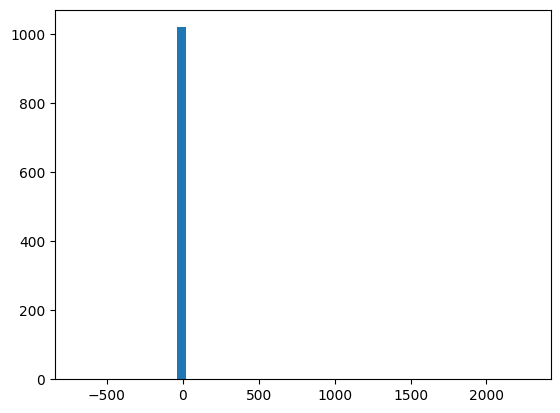

In [8]:
# whats the distribution of the mean value for each channel?
np.set_printoptions(precision=4)
print(channel_mean)
print(channel_mean.max())
print(channel_mean.min())
print(channel_mean.mean())
print(channel_mean.std())
_ = plt.hist(channel_mean.cpu().numpy(), bins=50)

tensor([ 6.3431,  7.2053,  6.3218,  ...,  6.8288, 14.7095,  6.6844],
       device='cuda:2')
tensor([ 6.3431,  7.2053,  6.3218,  ...,  6.8288, 14.7095,  6.6844],
       device='cuda:2')
tensor(209.4723, device='cuda:2')
tensor(4.7916, device='cuda:2')
tensor(7.4355, device='cuda:2')
tensor(6.8485, device='cuda:2')


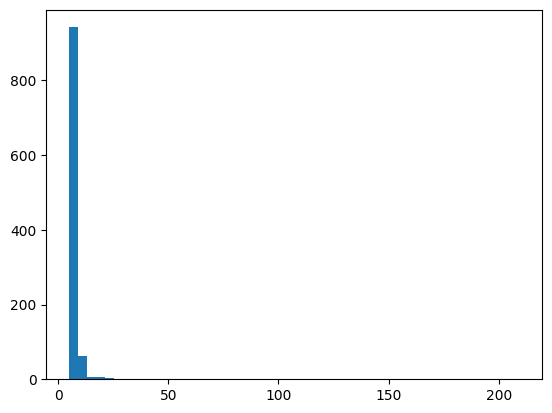

In [9]:
# whats the distribution of the std value for each channel?

channel_std = torch.sqrt(((s_ - channel_mean)**2 * mask).sum(dim=(0,1)) / mask.sum(dim=(0,1)))
print(channel_std)
print(channel_std)
print(channel_std.max())
print(channel_std.min())
print(channel_std.mean())
print(channel_std.std())
_ = plt.hist(channel_std.cpu().numpy(), bins=50)

In [10]:
def loop_through_batches(dataloader):
    all_arrays = []
    total_n_samples = 0
    for batch in tqdm(dataloader):
        if total_n_samples >= num_to_calculate:
            break 
        sequences = K.utils.get_random_sequence_crop_batch(batch[1], 512)
        with torch.no_grad():
            output = esmfold.infer_embedding(sequences)
        s, mask = output['s'], output['mask']
        mask = mask.unsqueeze(-1).expand_as(s)
        s_ = s * mask
        all_arrays.append(K.utils.npy(s_))
        total_n_samples += s.shape[0]
    return np.concatenate(all_arrays)

In [11]:
embs = loop_through_batches(dataloader)

  0%|          | 0/2402222 [00:00<?, ?it/s]

  0%|          | 79/2402222 [06:48<3449:43:47,  5.17s/it]


In [12]:
channel_mean = embs.mean(axis=(0,1))
channel_std = embs.std(axis=(0,1))

In [15]:
# with open("/home/amyxlu/kdiffusion/cached_tensors/subset_5000_oct24/channel_mean.pkl.npy", "wb") as f:
#     np.save(f, channel_mean, allow_pickle=True)

# with open("/home/amyxlu/kdiffusion/cached_tensors/subset_5000_oct24/channel_std.pkl.npy", "wb") as f:
#     np.save(f, channel_std, allow_pickle=True)


In [17]:
normalized = K.normalization._standardize(s_, channel_mean, channel_std)

tensor(0.0002, device='cuda:2') tensor(1.0415, device='cuda:2') tensor(8.2176, device='cuda:2') tensor(-8.6989, device='cuda:2')


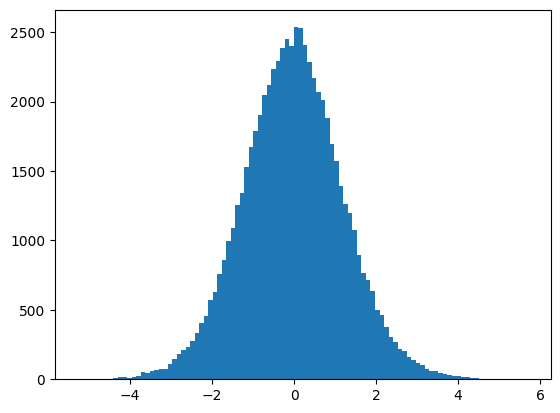

In [18]:
_ = plt.hist(normalized[:, 10, :].flatten().cpu().numpy(), bins=100)
print(normalized.mean(), normalized.std(), normalized.max(), normalized.min())